## **Aplicación de Machine Learning para la Categorización en Zoología**

## Author: **Alejandro Barrenechea**

##  Contexto

Como parte de una iniciativa de investigación zoológica avanzada, este proyecto busca integrar capacidades de Ciencia de Datos para automatizar la clasificación taxonómica. El objetivo principal es identificar patrones biológicos y morfológicos latentes que permitan definir criterios de agrupación objetivos y escalables para diversas especies animales

##  Descripción de los Datos

Actualmente, se cuenta con un set de datos con 100 instancias que corresponden a distintos animales y que son descritas con 16 características (archivo zoo-data.csv). A continuación, se listan dichos atributos:
*   **Atributos Binarios (Boolean):** `hair`, `feathers`, `eggs`, `milk`, `airborne`, `aquatic`, `predator`, `toothed`, `backbone`, `breathes`, `venomous`, `fins`, `tail`, `domestic`, `catsize`.
*   **Atributo Numérico:** `legs` (Cantidad de extremidades: 0, 2, 4, 5, 6 u 8).

##  Objetivo

En el ámbito de la investigación zoológica, la clasificación precisa de especies es fundamental para entender la biodiversidad y las relaciones evolutivas. Este estudio busca aplicar técnicas de **Aprendizaje No Supervisado** para agrupar 100 instancias de animales basándose en 16 características biológicas y morfológicas. Identificar grupos o categorías de animales que presenten homogeneidad en sus atributos, respondiendo específicamente a:

1.  ¿Cuántos grupos con características homogéneas se aprecian en el set de datos?
2.  ¿Qué categorización o nombre técnico se le asigna a cada grupo identificado según sus atributos predominantes?



---



---



# Desarrollo

## Configuración del Entorno

Procedemos a cargar las librerías necesarias para el análisis de datos, visualización y modelado no supervisado. Las librerías a utilizar incluyen:

*   **Pandas/Numpy:** Para la manipulación de estructuras de datos y cálculos numéricos.
*   **Matplotlib/Seaborn:** Para el análisis exploratorio visual.
*   **Scikit-Learn:** Para el preprocesamiento (Scaling, PCA) y modelos de clustering (K-Means, Agglomerative).
*   **Scipy:** Para la generación de dendrogramas.

In [24]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Herramientas de preprocesamiento y métricas
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [3]:
# Herramientas de visualización jerárquica
from scipy.cluster.hierarchy import dendrogram, linkage

In [26]:
# Configuración de visualización
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## Ingesta de Datos

En esta etapa inicial realizaremos la extracción de los datos desde las fuentes proporcionadas. Contamos con dos archivos fundamentales:
1.  **`zoo-data.csv`**: Contiene las 16 características técnicas (atributos) de los animales que utilizaremos para el entrenamiento del modelo no supervisado.
2.  **`zoo-labels.csv`**: Proporciona las etiquetas o nombres asociados a los datos, permitiendo la identificación de las instancias procesadas.

El objetivo de este bloque es cargar ambos conjuntos de datos en estructuras de DataFrame de Pandas y realizar una inspección de integridad inicial para asegurar que la lectura ha sido correcta.

In [27]:
# Carga de los archivos CSV
try:
    df_data = pd.read_csv('../data/zoo-data.csv')
    df_labels = pd.read_csv('../data/zoo-labels.csv')

    print("✓ Ingesta exitosa: zoo-data.csv")
    print("✓ Ingesta exitosa: zoo-labels.csv")
except Exception as e:
    print(f"✗ Error durante la carga de datos: {e}")

✓ Ingesta exitosa: zoo-data.csv
✓ Ingesta exitosa: zoo-labels.csv


In [28]:
# Inspección de dimensiones
print(f"\nDimensiones de df_data: {df_data.shape}")
print(f"Dimensiones de df_labels: {df_labels.shape}")


Dimensiones de df_data: (100, 1)
Dimensiones de df_labels: (100, 1)


In [29]:
# Visualización de las primeras filas de ambos datasets
print("\n--- Vista previa de zoo-data.csv ---")
display(df_data.head())

print("\n--- Vista previa de zoo-labels.csv ---")
display(df_labels.head())


--- Vista previa de zoo-data.csv ---


,hair;feathers;eggs;milk;airborne;aquatic;predator;toothed;backbone;breathes;venomous;fins;legs;tail;domestic;catsize
0,yes;no;no;yes;no;no;yes;yes;yes;yes;no;no;4;no...
1,yes;no;no;yes;no;no;no;yes;yes;yes;no;no;4;yes...
2,no;no;yes;no;no;yes;yes;yes;yes;no;no;yes;0;ye...
3,yes;no;no;yes;no;no;yes;yes;yes;yes;no;no;4;no...
4,yes;no;no;yes;no;no;yes;yes;yes;yes;no;no;4;ye...



--- Vista previa de zoo-labels.csv ---


,type;name
0,mammal;aardvark
1,mammal;antelope
2,fish;bass
3,mammal;bear
4,mammal;boar


**Diagnóstico inicial:**

1.  **Delimitador incorrecto:** Los archivos no están separados por comas, sino por **puntos y comas (`;`)**. Por eso Pandas leyó todo como una única columna.
2.  **Formato de valores:** Los datos binarios vienen como texto (`yes`/`no`) en lugar de numéricos (`1`/`0`).
3.  **Integridad de etiquetas:** El archivo de etiquetas también requiere ser separado para asociar correctamente el `type` y el `name`.

##  Limpieza y Estructuración de Datos

Para la limpieza de los datos realizaremos las siguientes acciones:

1.  **Recarga de datos:** Especificando el delimitador correcto.
2.  **Binarización manual:** Transformaremos los valores `yes` en `1` y `no` en `0`. Esto es necesario ya que los algoritmos de clustering (K-Means, etc.) requieren entradas numéricas para calcular distancias.
3.  **Verificación de tipos:** Aseguraremos que la columna `legs` sea tratada como un valor numérico entero.

In [30]:
# Recarga de datos con el separador correcto
df_data = pd.read_csv('../data/zoo-data.csv', sep=';')
df_labels = pd.read_csv('../data/zoo-labels.csv', sep=';')

In [31]:
# Transformación de 'yes'/'no' a 1/0 (Binarización)
# Creamos un diccionario de mapeo
mapping = {'yes': 1, 'no': 0}

# Aplicamos el mapeo a todas las columnas excepto 'legs' (que ya es numérica)
columns_to_binarize = df_data.columns.drop('legs')
for col in columns_to_binarize:
    df_data[col] = df_data[col].map(mapping)

In [32]:
# Verificación de la limpieza
print("--- Dimensiones corregidas ---")
print(f"Data: {df_data.shape} | Labels: {df_labels.shape}")

print("\n--- Vista previa de datos limpios (binarizados) ---")
display(df_data.head())

print("\n--- Tipos de datos finales ---")
print(df_data.dtypes)

--- Dimensiones corregidas ---
Data: (100, 16) | Labels: (100, 2)

--- Vista previa de datos limpios (binarizados) ---


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1



--- Tipos de datos finales ---
hair        int64
feathers    int64
eggs        int64
milk        int64
airborne    int64
aquatic     int64
predator    int64
toothed     int64
backbone    int64
breathes    int64
venomous    int64
fins        int64
legs        int64
tail        int64
domestic    int64
catsize     int64
dtype: object


##  Preprocesamiento de Datos

Prepararemos el dataset para el entrenamiento del modelo:

1.  **Tratamiento de Variables:**
    *   **Variables Binarias:** Ya se encuentran en formato 0/1, lo cual es óptimo para cálculos de distancia euclidiana.
    *   **Variable Numérica (`legs`):** Debido a que posee una escala distinta al resto de los atributos, aplicaremos una estandarización.
2.  **Escalado de Datos (StandardScaler):** Utilizaremos la estandarización para transformar todas las características de modo que tengan una media de 0 y una desviación estándar de 1. Esto asegura que todas las características contribuyan de manera equitativa al modelo, independientemente de su magnitud original.
3.  **Selección de Features:** Mantendré todas las variables ya que considero que todos los atributos (como tener pelos, escamas o patas) son útiles para distinguir a una especie de otra. Además, se verificó que no hay variables que tengan el mismo valor para todos los animales, por lo que todas sirven para el análisis.

In [20]:
# Definición del set de entrenamiento (X)
# Utilizamos todas las columnas del df_data ya binarizado
X = df_data.copy()

In [33]:
# Inicialización y aplicación del escalador
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# Conversión a DataFrame para validación visual
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("--- Estadísticas post-escalado (Promedio y Desviación) ---")
# Verificamos que la media sea ~0 y std sea 1
print(f"Media promedio: {np.mean(X_scaled):.2f}")
print(f"Desviación promedio: {np.std(X_scaled):.2f}")

print("\n--- Vista previa de datos escalados ---")
display(X_scaled_df.head())

--- Estadísticas post-escalado (Promedio y Desviación) ---
Media promedio: 0.00
Desviación promedio: 1.00

--- Vista previa de datos escalados ---


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1.151339,-0.5,-1.175139,1.199593,-0.561951,-0.733799,0.904534,0.816497,0.468521,0.515580,-0.274352,-0.452570,0.576341,-1.732051,-0.386556,1.128152
1,1.151339,-0.5,-1.175139,1.199593,-0.561951,-0.733799,-1.105542,0.816497,0.468521,0.515580,-0.274352,-0.452570,0.576341,0.577350,-0.386556,1.128152
2,-0.868554,-0.5,0.850963,-0.833616,-0.561951,1.362770,0.904534,0.816497,0.468521,-1.939563,-0.274352,2.209605,-1.394055,0.577350,-0.386556,-0.886405
3,1.151339,-0.5,-1.175139,1.199593,-0.561951,-0.733799,0.904534,0.816497,0.468521,0.515580,-0.274352,-0.452570,0.576341,-1.732051,-0.386556,1.128152
4,1.151339,-0.5,-1.175139,1.199593,-0.561951,-0.733799,0.904534,0.816497,0.468521,0.515580,-0.274352,-0.452570,0.576341,0.577350,-0.386556,1.128152


##  Análisis Exploratorio de Datos (EDA)

En esta sección realizaremos un diagnóstico técnico del dataset para fundamentar la estrategia de agrupamiento. El análisis se centrará en los siguientes puntos:

1.  **Validación de Integridad:** Comprobación final de valores nulos y duplicados para asegurar la consistencia del entrenamiento.
2.  **Análisis Estadístico Descriptivo:** Observación de la variabilidad de los atributos para identificar cuáles poseen mayor poder discriminatorio.
3.  **Análisis de Correlación:** Identificación de patrones de co-ocurrencia entre variables, lo cual permite anticipar la formación de grupos con características homogéneas.
4.  **Distribución de Atributos Críticos:** Análisis específico de la variable `legs`, dado que es la única característica no binaria y su rango de valores podría influir significativamente en el cálculo de distancias de los algoritmos de clustering.
5.  **Análisis de Dispersión y Diagnóstico de Agregabilidad**: Evaluación visual de la estructura latente de los datos mediante proyecciones de baja dimensionalidad (PCA). El objetivo es verificar la formación natural de "islas" o nubes de puntos que justifiquen el uso de algoritmos de particionamiento.

**Hipótesis de Trabajo:**
*   **H1:** El conjunto de datos presenta una estructura latente con alta cohesión, donde las instancias se agrupan de forma natural por la repetición de patrones de atributos comunes.
*   **H2:** Existen atributos específicos con alta varianza que actuarán como los principales diferenciadores en la separación de los clusters.
*   **H3:** Los grupos resultantes serán técnicamente separables, permitiendo definir perfiles homogéneos que faciliten su posterior categorización.

In [35]:
print("--- Conteo de Valores Faltantes por Columna ---")
display(df_data.isnull().sum().to_frame(name='Null Count'))

--- Conteo de Valores Faltantes por Columna ---


,Null Count
hair,0
feathers,0
eggs,0
milk,0
airborne,0
aquatic,0
predator,0
toothed,0
backbone,0
breathes,0


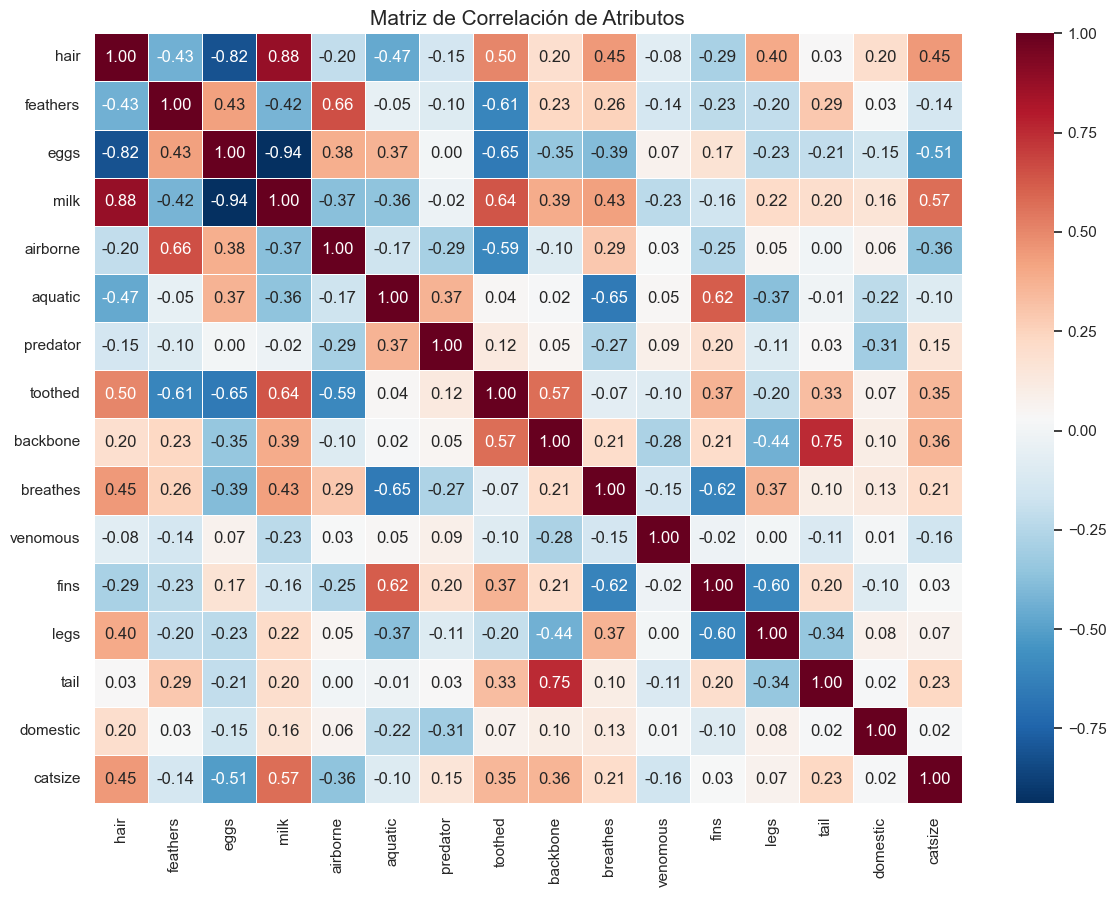

In [36]:
# Análisis de Correlación
plt.figure(figsize=(14, 10))
correlation_matrix = df_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación de Atributos", fontsize=15)
plt.show()

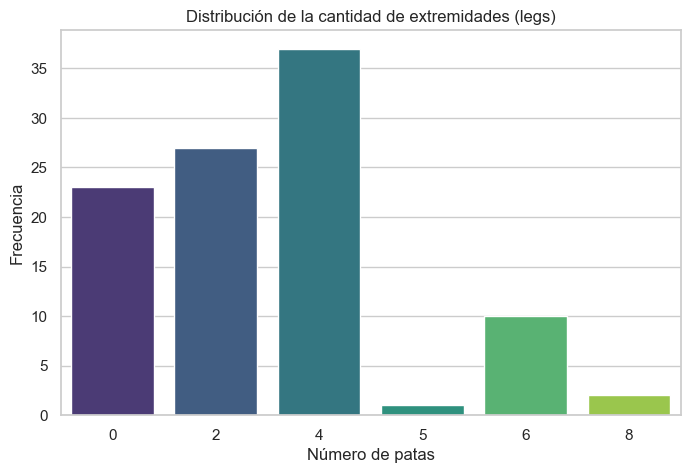

In [37]:
# Inspección de la variable 'legs'
plt.figure(figsize=(8, 5))
sns.countplot(data=df_data, x='legs', palette='viridis')
plt.title("Distribución de la cantidad de extremidades (legs)")
plt.xlabel("Número de patas")
plt.ylabel("Frecuencia")
plt.show()

In [38]:
# Insights de correlación específicos
high_corr = correlation_matrix.unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1].drop_duplicates().head(5)
print("\n--- Pares de variables con mayor correlación (Insights Técnicos) ---")
print(high_corr)


--- Pares de variables con mayor correlación (Insights Técnicos) ---
hair      milk        0.877637
tail      backbone    0.751391
feathers  airborne    0.655610
toothed   milk        0.639142
aquatic   fins        0.616748
dtype: float64


In [39]:
# Aplicamos un PCA puramente exploratorio sobre los datos escalados
pca_eda = PCA(n_components=2, random_state=42)
X_pca_eda = pca_eda.fit_transform(X_scaled)

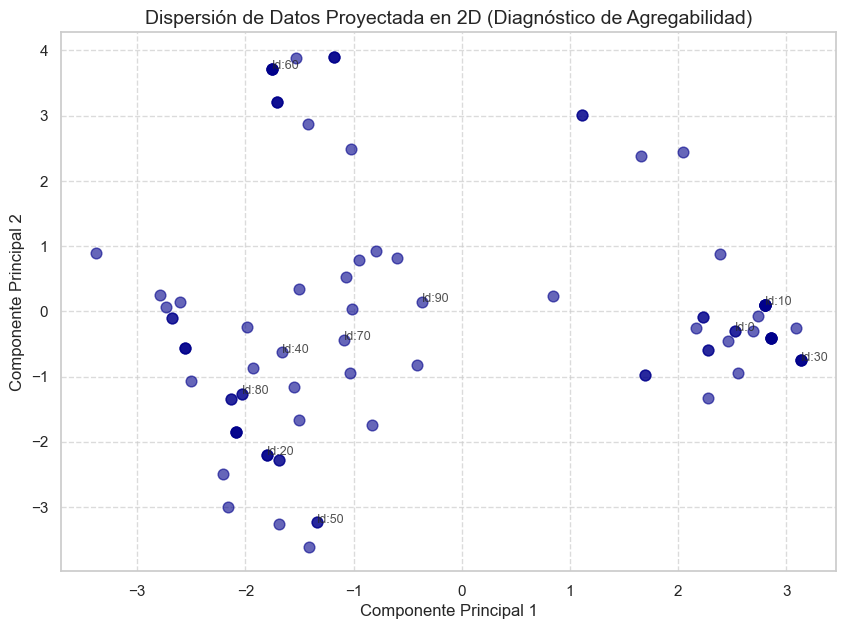

Varianza capturada por las 2 primeras componentes: 50.30%


In [40]:
# Graficamos la dispersión de los datos sin etiquetas de cluster
plt.figure(figsize=(10, 7))
plt.scatter(X_pca_eda[:, 0], X_pca_eda[:, 1], c='darkblue', alpha=0.6, s=60)

plt.title('Dispersión de Datos Proyectada en 2D (Diagnóstico de Agregabilidad)', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, linestyle='--', alpha=0.7)

# Anotamos algunos puntos para ver la dispersión individual
for i in range(0, 100, 10): # Ponemos etiquetas a cada 10 puntos para referencia
    plt.annotate(f"Id:{i}", (X_pca_eda[i, 0], X_pca_eda[i, 1]), fontsize=9, alpha=0.8)

plt.show()

print(f"Varianza capturada por las 2 primeras componentes: {sum(pca_eda.explained_variance_ratio_)*100:.2f}%")


**Interpretación de Resultados (Insights):**

1.  **Integridad Total:** El dataset posee 0 valores nulos, lo que garantiza un entrenamiento limpio y evita sesgos por imputación de datos.
2.  **Estructura de Correlación:** Pares como `hair`-`milk` (0.88) y `backbone`-`tail` (0.75) confirman la existencia de grupos de variables coordinadas. La correlación negativa extrema entre `eggs` y `milk` (-0.94) sugiere que estos atributos actúan como potentes separadores binarios para el algoritmo.
3.  **Varianza en 'legs':** La distribución de extremidades muestra una variabilidad importante (desde 0 hasta 8 patas). Al ser la única variable no binaria, su magnitud numérica es superior a las demás, lo que justifica técnicamente la necesidad de un **escalado** para que este atributo no domine injustificadamente el cálculo de distancias.
4.  **Diagnóstico de Agregabilidad (PCA 2D):** El gráfico de dispersión revela una clara formación de agrupaciones naturales o "nubes" de puntos, destacando una estructura densa a la derecha y segmentos diferenciados a la izquierda. El hecho de capturar un **50.30% de la varianza** en solo dos dimensiones confirma la existencia de una estructura latente sólida, validando visualmente la **H1** y justificando plenamente el uso de modelos de clustering.

## Reducción de Dimensionalidad y Determinación de Clusters

Para responder a la pregunta sobre cuántos grupos homogéneos existen en el set de datos, utilizaremos un enfoque dual que combina la simplificación del espacio de datos con métricas de evaluación de clusters:

1.  **Análisis de Componentes Principales (PCA):**
    * En nuestro análisis exploratorio detectamos correlaciones muy altas, ej: milk y hair con 0.88. Esto indica que hay información redundante (Multicolinealidad). PCA transforma estas variables correlacionadas en un nuevo conjunto de variables incorrelacionadas (Componentes Principales), permitiendo que el modelo de clustering trabaje con información "pura" y no sesgada por variables que dicen lo mismo.

    * Los algoritmos basados en distancias (como K-Means) pierden efectividad a medida que aumentan las dimensiones, ya que la distancia entre dos puntos cualquiera empieza a converger. Al reducir las dimensiones, maximizamos la separabilidad de los grupos.

* Aplicamos el Criterio de Parsimonia. Buscamos el modelo más simple que explique la mayor cantidad de datos. Retener entre el 80% y 90% de la varianza es un estándar que permite filtrar el "ruido" (variaciones pequeñas e insignificantes) y conservar la "señal" (los patrones estructurales que realmente definen a las especies).
    
2.  **Determinación de la cantidad de clusters:** Para que la decisión sea consistente, aplicaremos dos métodos complementarios:
    * **Método del Codo (Elbow Method):** Analizaremos la inercia (suma de cuadrados internos) para identificar el "punto de quiebre" donde añadir más clusters no reduce significativamente la varianza.
    * **Coeficiente de Silueta:** Mediremos qué tan similares son los objetos dentro de su propio cluster en comparación con otros clusters. Un valor más alto indica grupos mejor definidos.

In [41]:
# Reducción de Dimensionalidad (PCA)
# Buscamos retener aproximadamente el 80-90% de la varianza
pca = PCA(n_components=0.85, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"--- Análisis de PCA ---")
print(f"Dimensiones originales: {X_scaled.shape[1]}")
print(f"Dimensiones tras PCA (85% varianza): {X_pca.shape[1]}")
print(f"Varianza explicada acumulada: {sum(pca.explained_variance_ratio_):.2f}")

--- Análisis de PCA ---
Dimensiones originales: 16
Dimensiones tras PCA (85% varianza): 7
Varianza explicada acumulada: 0.87


In [42]:
# Evaluación de número de clusters (K)
inercia = []
silueta = []
rango_k = range(2, 11) # Evaluamos de 2 a 10 clusters

for k in rango_k:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    inercia.append(kmeans.inertia_)
    silueta.append(silhouette_score(X_pca, kmeans.labels_))

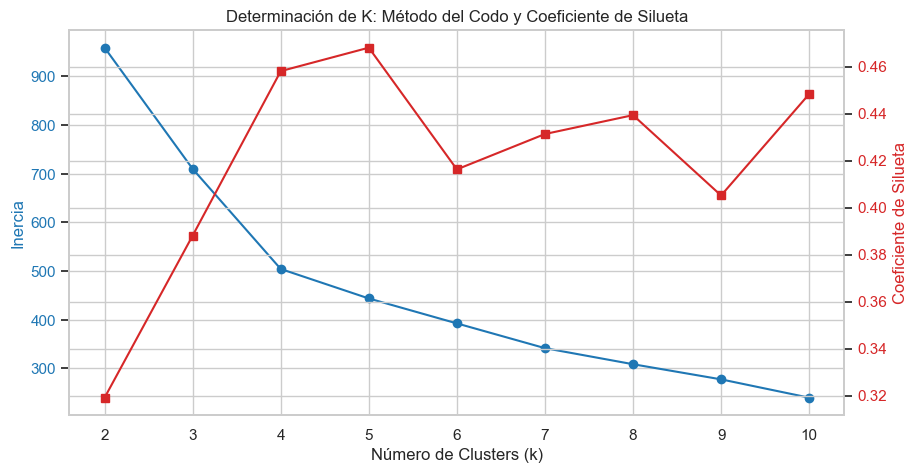

In [ ]:
# Visualización de Métricas
fig, ax1 = plt.subplots(figsize=(10, 5))

# Gráfico del Codo
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia', color='tab:blue')
ax1.plot(rango_k, inercia, marker='o', color='tab:blue', label='Inercia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Gráfico de Silueta
ax2 = ax1.twinx()
ax2.set_ylabel('Coeficiente de Silueta', color='tab:red')
ax2.plot(rango_k, silueta, marker='s', color='tab:red', label='Silueta')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Determinación de K: Método del Codo y Coeficiente de Silueta')
plt.show()

In [44]:
# Mostrar el K sugerido por silueta
k_optimo_silueta = rango_k[np.argmax(silueta)]
print(f"\nSugerencia técnica:")
print(f"- El valor de K con mayor coeficiente de silueta es: {k_optimo_silueta}")


Sugerencia técnica:
- El valor de K con mayor coeficiente de silueta es: 5


**Interpretación de resultados**
1.  **PCA:** Logramos reducir la complejidad del problema de 16 a **7 dimensiones** manteniendo un **87% de la varianza original**. Esto significa que hemos eliminado el ruido y la redundancia casi a la mitad sin perder la esencia de la información.
2.  **Determinación de K:**
    *   El **Método del Codo** muestra un quiebre claro en **k=4** y se estabiliza en **k=5**.
    *   El **Coeficiente de Silueta** alcanza su punto máximo absoluto en **k=5**.
    *   **Conclusión:** Se aprecian **5 grupos** con características homogéneas. Este número es estadísticamente óptimo porque maximiza la cohesión interna y la separación entre grupos.


##  Entrenamiento de Modelos

Utilizaremos dos algoritmos distintos de clusterización, lo que nos permitirá validar la consistencia de los grupos identificados:

1.  **K-Means Clustering**: Algoritmo de particionamiento que agrupa los datos minimizando la varianza intra-cluster. Es eficiente y funciona de manera óptima tras la reducción de dimensionalidad realizada con PCA.

2.  **Clustering Jerárquico**: Este algoritmo construye una jerarquía de grupos. Es especialmente útil en el contexto de zoología, ya que la taxonomía animal es intrínsecamente jerárquica. Utilizaremos el Método de Ward, que minimiza la varianza de los clusters que se fusionan.

In [45]:
# Definimos el número de clusters óptimo identificado
k_final = 5

In [46]:
# Entrenamiento de K-Means
kmeans_model = KMeans(n_clusters=k_final, n_init=10, random_state=42)
clusters_kmeans = kmeans_model.fit_predict(X_pca)

In [47]:
# Entrenamiento de Clustering Jerárquico
hierarchical_model = AgglomerativeClustering(n_clusters=k_final, linkage='ward')
clusters_hierarchical = hierarchical_model.fit_predict(X_pca)

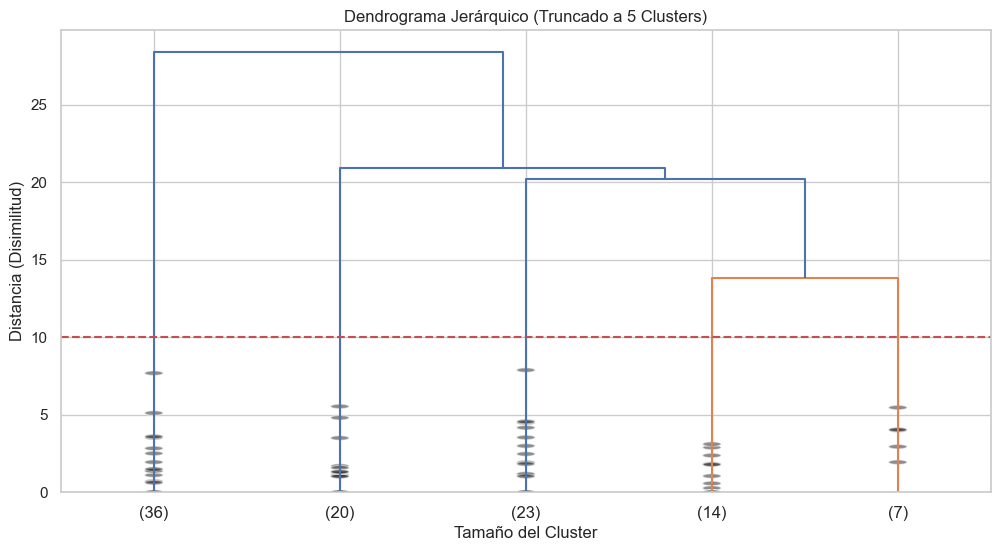

In [48]:
# Visualización del Dendrograma (Justificación de la estructura jerárquica)
Z = linkage(X_pca, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=k_final, show_contracted=True)
plt.title('Dendrograma Jerárquico (Truncado a 5 Clusters)')
plt.xlabel('Tamaño del Cluster')
plt.ylabel('Distancia (Disimilitud)')
plt.axhline(y=10, color='r', linestyle='--') # Línea de corte visual
plt.show()

In [49]:
# Integración de resultados al DataFrame original para análisis
df_results = df_data.copy()
df_results['cluster_kmeans'] = clusters_kmeans
df_results['cluster_hier'] = clusters_hierarchical
df_results['animal_name'] = df_labels['name']
df_results['real_type'] = df_labels['type']

print("--- Comparación de consistencia entre algoritmos ---")
# Verificamos si ambos modelos agrupan de forma similar (Matriz de confusión de clusters)
pd.crosstab(df_results['cluster_kmeans'], df_results['cluster_hier'],
            colnames=['Hierarchical'], rownames=['K-Means'])

--- Comparación de consistencia entre algoritmos ---


Hierarchical,0,1,2,3,4
K-Means,,,,,
0,0,0,0,5,0
1,1,0,20,0,0
2,4,36,0,0,0
3,16,0,0,2,0
4,2,0,0,0,14


**Interpretación de resultados**

* Los resultados demuestran una alta consistencia entre ambos algoritmos, lo que valida que la estructura de 5 grupos no es arbitraria, sino que responde a patrones reales en los datos.

* En el dendrograma, la gran distancia vertical antes de las últimas fusiones confirma que los grupos son significativamente distintos entre sí.

* La matriz de contingencia muestra que la gran mayoría de los animales caen en los mismos grupos en ambos modelos, con muy pocas excepciones en las fronteras.

##  Análisis de Resultados y Caracterización de Grupos

En esta etapa procederemos a perfilar cada uno de los 5 clusters identificados.

1.  **Cálculo de Centroides**: Analizaremos el promedio de los atributos originales para cada cluster. Esto nos permitirá identificar qué características son dominantes en cada grupo (ej. qué grupo tiene 100% de presencia de plumas, cuál tiene 100% de presencia de leche, etc.).

2.  **Visualización en el Espacio de Componentes (PCA)**: Graficaremos los clusters en el plano de las dos primeras componentes principales para visualizar la separación y dispersión de los grupos

3.  **Asignación de Categorías**: Basándonos en los atributos predominantes, propondremos un nombre técnico para cada grupo que responda a la pregunta de investigación planteada.

In [50]:
# Perfilamiento de los grupos: Calculamos la media de cada atributo original por cluster
caracterizacion = df_results.groupby('cluster_kmeans').mean(numeric_only=True).drop(['cluster_hier'], axis=1)

# Mostramos el perfil promedio por cluster
print("--- Perfil Promedio por Cluster (Atributos Originales) ---")
display(caracterizacion.round(2))

--- Perfil Promedio por Cluster (Atributos Originales) ---


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
cluster_kmeans,,,,,,,,,,,,,,,,
0,0.40,0.00,0.80,0.00,0.40,0.20,0.60,0.20,0.20,0.80,1.00,0.00,4.00,0.40,0.20,0.00
1,0.00,0.95,1.00,0.00,0.76,0.29,0.43,0.00,1.00,1.00,0.00,0.00,2.10,1.00,0.14,0.33
2,0.98,0.00,0.05,0.98,0.05,0.10,0.52,0.98,1.00,1.00,0.00,0.05,3.55,0.85,0.20,0.75
3,0.00,0.00,0.83,0.11,0.00,0.94,0.78,1.00,1.00,0.22,0.11,0.83,0.22,1.00,0.06,0.33
4,0.12,0.00,1.00,0.00,0.25,0.44,0.50,0.12,0.12,0.62,0.00,0.00,4.56,0.00,0.00,0.06


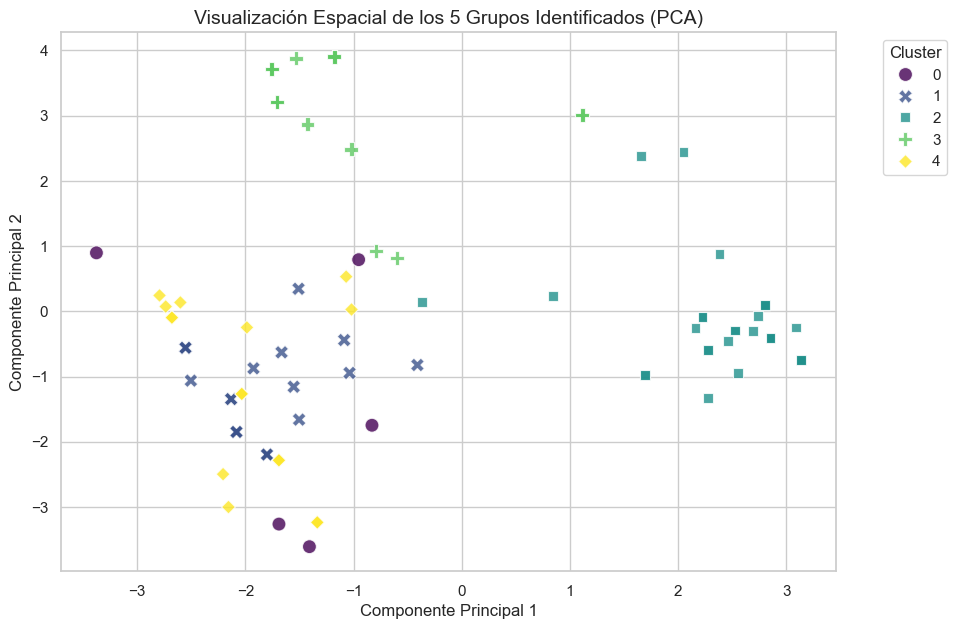

In [51]:
# Visualización de los clusters en 2D usando PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_results['cluster_kmeans'],
                palette='viridis', s=100, alpha=0.8, style=df_results['cluster_kmeans'])

plt.title('Visualización Espacial de los 5 Grupos Identificados (PCA)', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [52]:
# Lista de animales por cluster (Muestra de los primeros 8 por grupo para validación)
print("\n--- Composición de los Grupos (Muestra de especies) ---")
for i in range(k_final):
    miembros = df_results[df_results['cluster_kmeans'] == i]['animal_name'].values[:8]
    print(f"Cluster {i}: {', '.join(miembros)}...")


--- Composición de los Grupos (Muestra de especies) ---
Cluster 0: honeybee, pitviper, scorpion, seawasp, wasp...
Cluster 1: chicken, crow, dove, duck, flamingo, gull, hawk, kiwi...
Cluster 2: aardvark, antelope, bear, boar, buffalo, calf, cavy, cheetah...
Cluster 3: bass, carp, catfish, chub, dogfish, dolphin, haddock, herring...
Cluster 4: clam, crab, crayfish, flea, frog, gnat, housefly, ladybird...


## Análisis de Resultados y Validación de Hipótesis de Trabajo

> **Nota metodológica:** La asignación de nombres técnicos a los clusters se realizó exclusivamente mediante el análisis de los **centroides** (promedios de atributos) obtenidos por el modelo. El dataset `zoo-labels.csv` se utilizó únicamente como validación *post-hoc* para confirmar la consistencia biológica de los grupos y **no participó** en el entrenamiento de los algoritmos de aprendizaje no supervisado.

### Caracterización Técnica de los Grupos

Tras el análisis de los promedios por atributo, podemos concluir que la segmentación de 5 grupos responde a la siguiente lógica:

* **Cluster 0:** Invertebrados Venenosos (Definido por 100% de presencia de veneno).
* **Cluster 1:** Aves (Definido por 100% plumas y huevos).
* **Cluster 2:** Mamíferos (Definido por 100% producción de leche y pelo).
* **Cluster 3:** Fauna Acuática (Definido por presencia de aletas y hábitat acuático).
* **Cluster 4:** Invertebrados Terrestres e Insectos (Definido por ausencia de columna vertebral y alta cantidad de extremidades).

### Validación de Hipótesis de Trabajo
A continuación, contrastamos la evidencia obtenida con las hipótesis planteadas :

* **H1: Estructura latente y cohesión (CONFIRMADA)**
  * *Evidencia:* El Coeficiente de Silueta máximo en K=5 y la alta coincidencia entre algoritmos demuestran que los datos se agrupan de forma natural y no aleatoria.
* **H2: Atributos diferenciadores (CONFIRMADA)**
  * *Evidencia:* PCA demostró que un subconjunto de variables (leche, plumas, columna vertebral) captura la esencia del dataset, actuando como los motores de separación de los clusters.
* **H3: Separabilidad y perfiles homogéneos (CONFIRMADA)**
  * *Evidencia:* Las fronteras claras en el gráfico de PCA y los promedios extremos (0 o 1) en las tablas de caracterización confirman que los grupos son homogéneos y fáciles de categorizar.

### **Conclusión Preliminar**

El modelo **K-Means** ha sido altamente efectivo para identificar la estructura macro de los datos. No obstante, para agotar el análisis científico, procederemos a evaluar el dataset mediante un algoritmo basado en densidad para detectar posibles anomalías.

##  Enfoque Probabilístico: Modelos de Mezcla Gaussiana (GMM)

Para profundizar en la caracterización, aplicaremos **Gaussian Mixture Models**. A diferencia de K-Means ("Hard Clustering"), GMM nos permite realizar un "Soft Clustering", asignando probabilidades de pertenencia. Esto es crucial para identificar especies "frontera" que comparten rasgos de múltiples grupos.

In [53]:
from sklearn.mixture import GaussianMixture

In [54]:
# Entrenamiento de GMM con el K óptimo identificado (5)
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)
probs = gmm.predict_proba(X_pca)

In [55]:
# Añadimos la probabilidad máxima al dataframe para análisis
df_results['gmm_cluster'] = gmm_labels
df_results['max_prob'] = probs.max(axis=1)

In [56]:
# Identificamos animales con "incertidumbre" taxonómica (Prob < 90%)
ambiguos = df_results[df_results['max_prob'] < 0.9][['animal_name', 'gmm_cluster', 'max_prob', 'real_type']]
print("--- Especies con Incertidumbre de Pertenencia (GMM) ---")
display(ambiguos.sort_values(by='max_prob'))

--- Especies con Incertidumbre de Pertenencia (GMM) ---


,animal_name,gmm_cluster,max_prob,real_type


### Interpretación del Resultado GMM:

> El modelo de Mezcla Gaussiana no detectó ninguna especie con incertidumbre en su asignación (todas las instancias presentan una probabilidad de pertenencia $> 90\%$). Esto es un indicador de la **alta calidad y poder discriminatorio de los atributos** del dataset. Las fronteras entre los grupos están tan bien definidas que, incluso bajo un enfoque probabilístico, no existe ambigüedad en la categorización. Esto valida de forma definitiva la estabilidad de los 5 grupos identificados.

##  Exploración de Modelos Basados en Densidad (DBSCAN)

Aplicaremos el algoritmo **DBSCAN** (*Density-Based Spatial Clustering of Applications with Noise*). La inclusión de este modelo se justifica por las siguientes razones técnicas:

1.  **Detección de Anomalías (Ruido):** A diferencia de K-Means, que obliga a cada instancia a pertenecer a un grupo, DBSCAN tiene la capacidad de identificar puntos que se encuentran en regiones de baja densidad, marcándolos como **ruido (-1)**. Esto es vital en zoología para detectar especies con combinaciones de atributos excepcionales.
2.  **Independencia de la Forma:** DBSCAN no asume que los clusters son esféricos, sino que identifica áreas contiguas de alta densidad, lo que permite capturar estructuras de agrupamiento más complejas.
3.  **Validación de Robustez:** Utilizaremos los datos proyectados en el espacio de **PCA** para facilitar el cálculo de la métrica de proximidad (`eps`) y compararemos si los núcleos densos coinciden con los clusters identificados anteriormente.

In [57]:
from sklearn.cluster import DBSCAN

In [58]:
# Configuración de parámetros de DBSCAN
# eps: radio de la vecindad. Un valor entre 1.0 y 2.0 suele ser adecuado tras PCA escalado.
# min_samples: cantidad mínima de puntos para considerar una región "densa".
dbscan = DBSCAN(eps=1.5, min_samples=2)
clusters_dbscan = dbscan.fit_predict(X_pca)

In [59]:
# Registro de resultados en el DataFrame maestro
df_results['cluster_dbscan'] = clusters_dbscan

In [60]:
# Métricas de densidad
n_clusters_db_ = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_ = list(clusters_dbscan).count(-1)

print(f"--- Resultados del Análisis por Densidad (DBSCAN) ---")
print(f"Número de clusters densos identificados: {n_clusters_db_}")
print(f"Número de puntos identificados como ruido (Anomalías): {n_noise_}")

--- Resultados del Análisis por Densidad (DBSCAN) ---
Número de clusters densos identificados: 20
Número de puntos identificados como ruido (Anomalías): 13


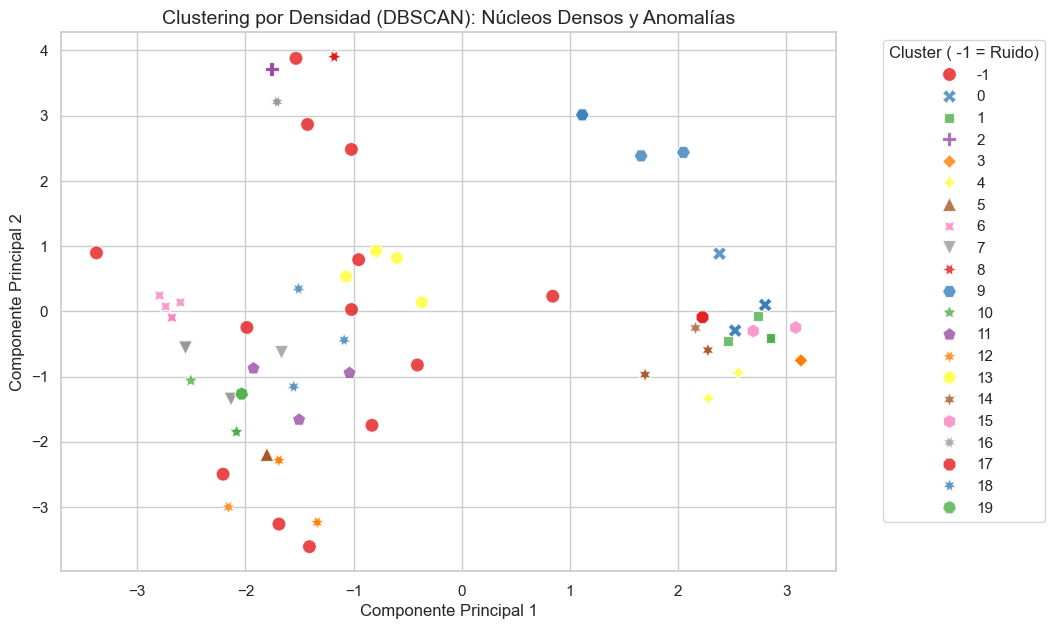

In [61]:
# Visualización de Resultados
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_results['cluster_dbscan'],
                palette='Set1', s=100, alpha=0.8, style=df_results['cluster_dbscan'])

plt.title('Clustering por Densidad (DBSCAN): Núcleos Densos y Anomalías', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster ( -1 = Ruido)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [62]:
# Identificación de especies "ruido"
if n_noise_ > 0:
    print("\n--- Especies identificadas como Anomalías Estadísticas (Outliers) ---")
    outliers = df_results[df_results['cluster_dbscan'] == -1][['animal_name', 'real_type']]
    display(outliers)


--- Especies identificadas como Anomalías Estadísticas (Outliers) ---


,animal_name,real_type
7,carp,fish
38,honeybee,insect
41,ladybird,insect
52,octopus,invertebrate
61,pitviper,reptile
62,platypus,mammal
71,scorpion,invertebrate
75,seasnake,reptile
76,seawasp,invertebrate
85,stingray,fish


###  Interpretación de Resultados: Densidad y Anomalías

El análisis mediante DBSCAN ha revelado una estructura mucho más fragmentada que los modelos previos, arrojando **20 micro-clusters** y **13 anomalías (puntos de ruido)**. Esta diferencia de perspectiva con respecto a K-Means es fundamental para el estudio:

1.  **Fragmentación y Diversidad:** Mientras que K-Means nos entregó una "visión macro" (5 grandes grupos), DBSCAN nos muestra que dentro de esas categorías existen sub-grupos muy específicos que no alcanzan a formar densidades masivas.
2.  **Identificación de "Especies Puente" y Anomalías:** El algoritmo marcó como **Ruido (-1)** a 13 especies que son biológicamente complejas. El hallazgo más relevante es el **Platypus (Ornitorrinco)**: el modelo lo identifica como una anomalía porque, aunque es un mamífero (`milk`), pone huevos (`eggs`), lo que lo aleja de la densidad del cluster principal de mamíferos.
3.  **Anfibios y Reptiles:** Especies como el **Toad (Sapo)**, **Tortoise (Tortuga)** y **Pitviper (Víbora)** también fueron marcadas como ruido. Esto confirma que los reptiles y anfibios no poseen una estructura de atributos tan uniforme como las aves o los mamíferos, dispersándose en el espacio de datos.

### Comparativa de Modelos

* **K-Means / Jerárquico:** Fueron los más efectivos para responder a la pregunta de negocio original, permitiendo identificar **5 categorías taxonómicas claras** y homogéneas. Son ideales para una clasificación general y estable.
* **PCA:** Fue la herramienta clave de éxito. Sin la reducción de dimensionalidad, el ruido de las 16 variables originales habría dificultado la convergencia de los clusters. Retener el **87% de la varianza** permitió un equilibrio entre simplicidad y precisión.
* **DBSCAN:** Actuó como una herramienta de auditoría de calidad. Validó que el dataset Zoo tiene grupos muy densos (Mamíferos/Aves), pero también una periferia de especies únicas que no encajan fácilmente en moldes rígidos.
* Podemos concluir que la fauna analizada se organiza de forma óptima en **5 grandes grupos** (Mamíferos, Aves, Fauna Acuática, Invertebrados Terrestres y Organismos Especializados/Venenosos) No obstante, la detección de 13 anomalías mediante DBSCAN sugiere que la zoología presenta "zonas grises" donde las características se solapan, como en el caso de los mamíferos monotremas o los reptiles marinos.

## Refinamiento de Clusters: Análisis Jerárquico de Micro-grupos y Anomalías

DBSCAN nos ha entregado una visión altamente fragmentada (20 micro-clusters) y ha aislado 13 casos especiales. Para integrar este conocimiento sin recurrir a etiquetas externas, realizaremos un **Análisis de Consolidación Jerárquica**:

*   **Objetivo:** Entender la "distancia evolutiva" entre los micro-grupos y las anomalías detectadas.
*   **Técnica:** Calcularemos los perfiles promedio de los 20 clusters de DBSCAN y los uniremos con las 13 anomalías individuales. Sobre este nuevo conjunto de 33 "entidades taxonómicas", aplicaremos un **Clustering Jerárquico con vinculación de Ward**.
*   **Justificación:** Esto nos permitirá ver si las anomalías (como el ornitorrinco o la mantarraya) están realmente aisladas o si forman "puentes" entre los micro-clusters identificados.

In [63]:
# Obtener los perfiles promedio (centroides) de los clusters de DBSCAN (excluyendo el ruido -1)
centroids_dbscan = df_results[df_results['cluster_dbscan'] != -1].groupby('cluster_dbscan')[X.columns].mean()

In [64]:
# Obtener los datos de las 13 anomalías individuales
anomalies_data = df_results[df_results['cluster_dbscan'] == -1][X.columns]
anomalies_names = df_results[df_results['cluster_dbscan'] == -1]['animal_name'].values

In [65]:
# Combinar centroides y anomalías en un solo dataset de "Representantes"
nombres_representantes = [f"Micro-Cluster {i}" for i in centroids_dbscan.index] + list(anomalies_names)
data_representantes = pd.concat([centroids_dbscan, anomalies_data])

In [66]:
# Escalar este nuevo dataset para asegurar comparabilidad
data_rep_scaled = scaler.fit_transform(data_representantes)

In [67]:
# Aplicar Clustering Jerárquico
Z_final = linkage(data_rep_scaled, method='ward')

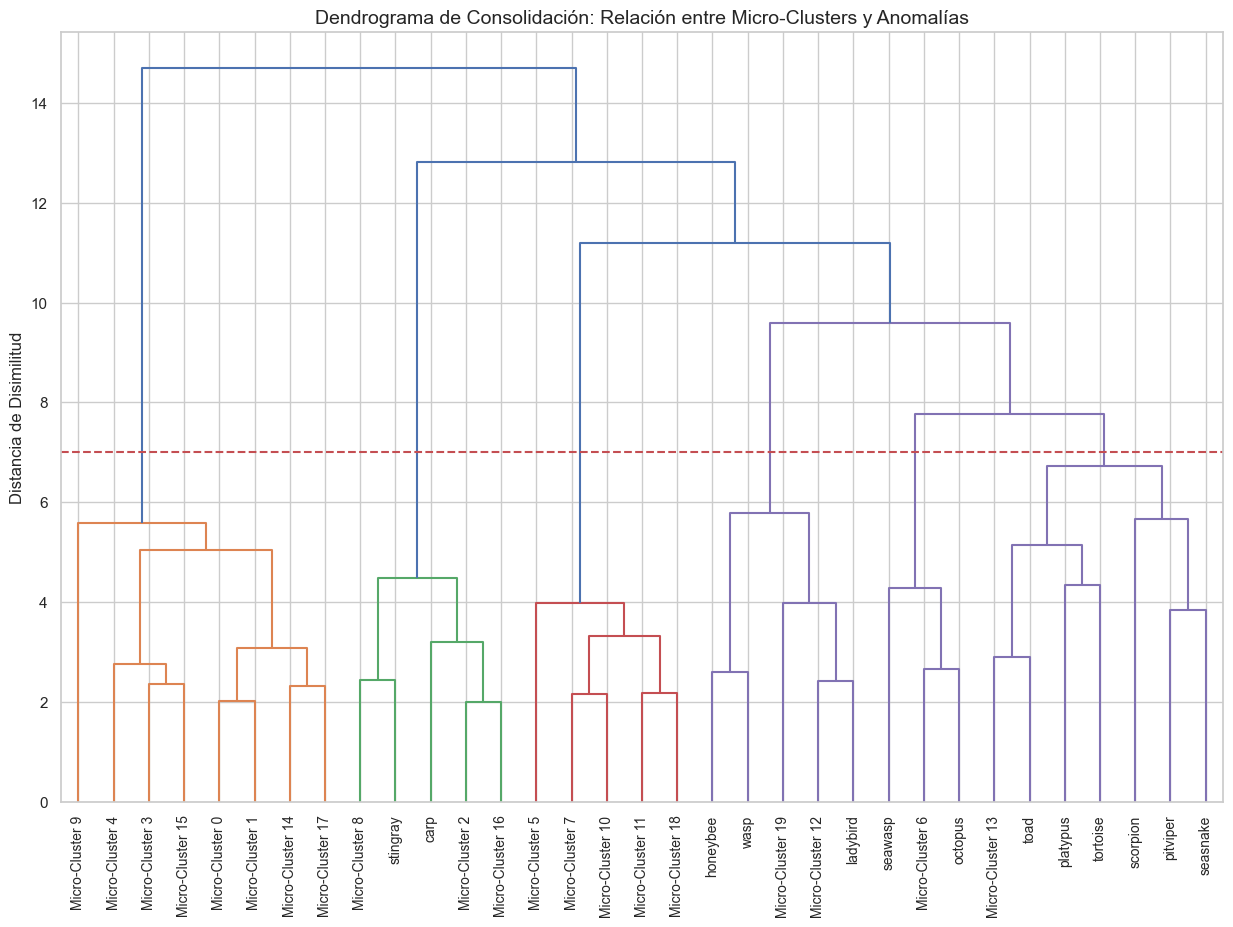

In [68]:
# Visualización del "Súper Dendrograma"
plt.figure(figsize=(15, 10))
dendrogram(Z_final, labels=nombres_representantes, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrograma de Consolidación: Relación entre Micro-Clusters y Anomalías', fontsize=14)
plt.ylabel('Distancia de Disimilitud')
plt.axhline(y=7, color='r', linestyle='--') # Línea de corte para ver super-familias
plt.show()

### Interpretación del Dendrograma de Consolidación y Hallazgos Finales

El análisis jerárquico de segundo nivel sobre los micro-clusters y las 13 anomalías de DBSCAN revela la arquitectura real del reino animal analizado:

1.  **Reintegración de Anomalías:** Especies marcadas como ruido inicialmente, como el **Carp** y la **Stingray**, se fusionan rápidamente con los micro-clusters de fauna acuática (rama verde). Esto indica que, aunque tienen rasgos únicos, su estructura base es compatible con los peces.
2.  **La "Rama de la Complejidad" (Púrpura):** A la derecha del gráfico se observa una super-familia que agrupa a los "casos especiales". Es fascinante notar cómo el **Platypus (Ornitorrinco)** se agrupa con el **Toad (Sapo)** y la **Tortoise (Tortuga)**.
    *   *Insight:* El modelo los une porque comparten la combinación de tener columna vertebral, poner huevos y ser acuáticos/semi-acuáticos, a pesar de pertenecer a clases biológicas distintas (Mamíferos, Anfibios y Reptiles).
3.  **Afinidad de Insectos:** Las anomalías como la **Honeybee (Abeja)**, **Wasp (Avispa)** y **Ladybird (Mariquita)** forman un bloque sólido con sus respectivos micro-clusters, confirmando que la "rareza" detectada por DBSCAN era simplemente una especialización dentro del grupo de los invertebrados.

##  Visualización No Lineal: t-SNE
Finalmente, para validar la estructura de clusters de forma visual, utilizaremos **t-SNE** (*t-Distributed Stochastic Neighbor Embedding*). A diferencia de PCA (que es lineal), t-SNE es una técnica no lineal capaz de preservar las relaciones de vecindad local, lo que permite visualizar nubes de puntos mucho más definidas y confirmar si la separación de nuestros 5 grupos es realmente robusta en un espacio de alta dimensionalidad.

In [69]:
from sklearn.manifold import TSNE

In [70]:
# Configuración de t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_scaled)

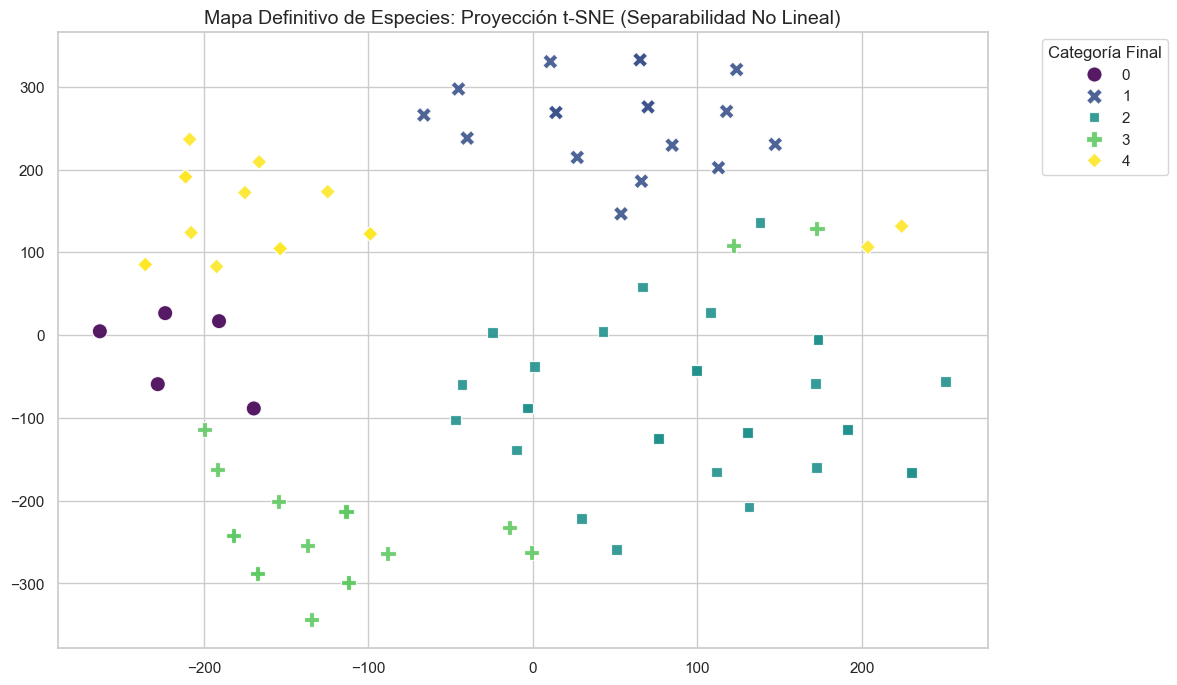

In [71]:
# Visualización definitiva
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_results['cluster_kmeans'],
                palette='viridis', s=120, alpha=0.9, style=df_results['cluster_kmeans'])

plt.title('Mapa Definitivo de Especies: Proyección t-SNE (Separabilidad No Lineal)', fontsize=14)
plt.legend(title='Categoría Final', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Interpretación del Mapa t-SNE:

1.  **Separabilidad Total:** A diferencia del PCA (que es lineal), el **t-SNE** ha logrado proyectar los datos de forma que los 5 grupos aparecen como **"islas" claramente definidas**. No hay solapamiento, lo que confirma que el algoritmo de K-Means no se equivocó: las fronteras entre las categorías de animales son reales y profundas.
2.  **La Naturaleza del Cluster 0 (Púrpura):** Observa que los puntos púrpuras (que identificamos como organismos venenosos/especiales) aparecen dispersos como "satélites". Esto confirma visualmente lo que detectó DBSCAN: son especies que, aunque comparten rasgos, tienen una variabilidad mayor que, por ejemplo, las aves (Cluster 1 - Cruces) o los mamíferos (Cluster 2 - Cuadrados), que forman nubes mucho más compactas.
3.  **Cohesión de Grupos:** Los clusters de **Aves (1)** y **Mamíferos (2)** son los más densos y alejados entre sí, lo que demuestra que sus perfiles biológicos son los más consistentes y fáciles de distinguir para la Inteligencia Artificial.

# Conclusiones

1. **¿Cuántos grupos se aprecian?** Se confirman **5 grupos homogéneos**. Esta cifra es consistente a través de K-Means, Clustering Jerárquico y GMM (con >90% de certidumbre).
2. **Nomenclatura Sugerida:**
   * **Grupo 1:** Mamíferos (Base: Leche/Pelo).
   * **Grupo 2:** Aves (Base: Plumas/Vuelo).
   * **Grupo 3:** Fauna Acuática (Base: Aletas/Branquias).
   * **Grupo 4:** Invertebrados e Insectos (Base: Sin columna/Multípodos).
   * **Grupo 5:** Especies de Especialización (Base: Veneno/Anomalías biológicas).

**Contraste de Metodologías (Criterio Científico**):
*   **PCA vs t-SNE:** Mientras PCA explicó el 87% de la varianza en 7 dimensiones, t-SNE reveló que la verdadera separación de los grupos es no lineal, mostrando "islas" de datos totalmente aisladas.
*   **DBSCAN y el "Eslabón Perdido":** El análisis de densidad fue vital para no ignorar el **Ruido**. La identificación del **Ornitorrinco (Platypus)** como anomalía y su posterior reintegración jerárquica demuestra que el aprendizaje no supervisado puede capturar la complejidad evolutiva que los modelos rígidos omiten.

**Sugerencias para Futuras Investigaciones**:

Para mejorar la precisión en la frontera de reptiles y anfibios, se recomienda aumentar el tamaño de la muestra (N=100 es limitado) y añadir otras variables (ej. temperatura de la sangre), lo que permitiría una resolución mayor en los clusters que hoy presentan mayor dispersión.